Text(0, 0.5, 'y')

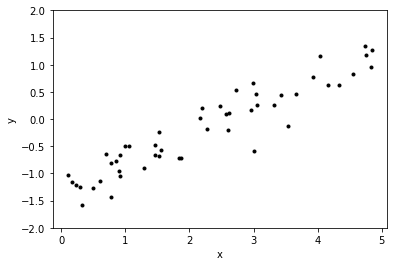

In [7]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

true_m = 0.5
true_b = -1.3
true_logs = np.log(0.3)

x = np.sort(np.random.uniform(0, 5, 50))
y = true_b + true_m * x + np.exp(true_logs) * np.random.randn(len(x))

plt.plot(x, y, ".k")
plt.ylim(-2, 2)
plt.xlabel("x")
plt.ylabel("y")

Using scipy curve_fit to do a least squares fit to give me some priors to feed into pymc3

In [1]:
from scipy.optimize import curve_fit

In [2]:
#defining a straight line function

def straight_line(m, x, c):
    return m*x + b

In [9]:
popt, pcov = curve_fit(straight_line, x, y)

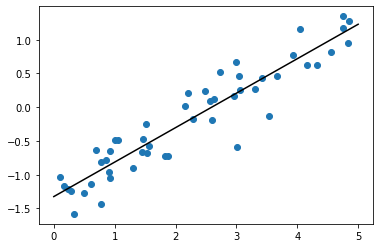

In [21]:
plt.scatter(x, y)
plt.plot(straight_line(popt[0], range(6), popt[1]), c='k')

In [30]:
err = np.sqrt(np.diag(pcov))

In [31]:
gradient_prior = popt[0]
intercept_prior = popt[1]

gradient_prior_err = 3*err[0]
intercept_prior_err = 3*err[1]

In [34]:
import pymc3 as pm

with pm.Model() as model:

    # Define the priors on each parameter:
    m = pm.Uniform("m", lower=gradient_prior-gradient_prior_err, upper=gradient_prior_err+gradient_prior)
    b = pm.Uniform("b", lower=intercept_prior-intercept_prior_err, upper=intercept_prior+intercept_prior_err)
    logs = pm.Uniform("logs", lower=-5, upper=5)

    # Define the likelihood. A few comments:
    #  1. For mathematical operations like "exp", you can't use
    #     numpy. Instead, use the mathematical operations defined
    #     in "pm.math".
    #  2. To condition on data, you use the "observed" keyword
    #     argument to any distribution. In this case, we want to
    #     use the "Normal" distribution (look up the docs for
    #     this).
    pm.Normal("obs", mu=m * x + b, sd=pm.math.exp(logs), observed=y)

    # This is how you will sample the model. Take a look at the
    # docs to see that other parameters that are available.
    trace = pm.sample(
        draws=5000, tune=5000, chains=50, cores=4, return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


KeyboardInterrupt: 

array([[<AxesSubplot:title={'center':'m'}>,
        <AxesSubplot:title={'center':'m'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'logs'}>,
        <AxesSubplot:title={'center':'logs'}>]], dtype=object)

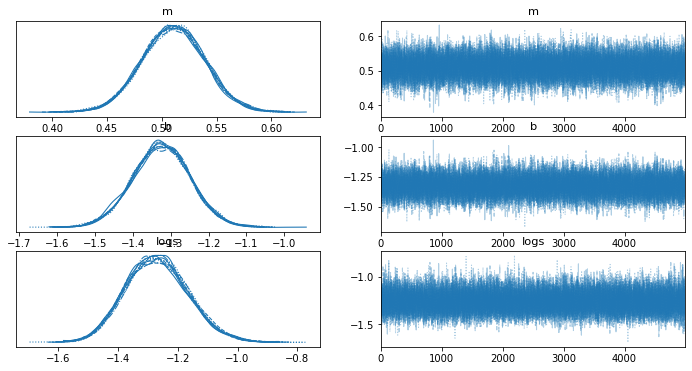

In [8]:
import arviz as az

az.plot_trace(trace, var_names=["m", "b", "logs"])

In [10]:
az.summary(trace, var_names=["m", "b", "logs"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m,0.511,0.029,0.457,0.565,0.000,0.000,19254.0,21075.0,1.0
b,-1.325,0.076,-1.470,-1.183,0.001,0.000,19386.0,20973.0,1.0
logs,-1.268,0.105,-1.466,-1.075,0.001,0.001,21620.0,17522.0,1.0
